<a href="https://colab.research.google.com/github/camilorey/material_clases/blob/main/SEIR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gekko

     |████████████████████████████████| 9.8MB 2.5MB/s 


Importamos de GEKKO el módulo para resolver problemas y vamos a usar NumPy para generar horizontes de simulación. 

También PyPlot para poder graficar.

In [ ]:
from gekko import GEKKO
import numpy as NumPy
import matplotlib.pyplot as PyPlot
import seaborn as SeaBorn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


El modelo epidemiológico SEIR divide una población de tamaño $N$ en cuatro categorías: los susceptibles $S$ que es la población que podría infectarse con la enfermedad, las personas que fueron expuestas a la enfermedad $E$; los infectados $I$ que pueden transmitir la enfermedad y los recuperados de la enfermedad $R$. Notemos que la población total se puede considerar en cada una de estas categorías. A saber:

>> $N = S+ E+  I+R$

Mientras que la población con una tasa de reemplazo poblacional $\mu$ y mueren por (causas no relacionadas con la enfermedad) al cabo de $1/\nu$ años. En este sentido, tenemos que 

>> $\mu = \nu{N}$

Vamos a considerar que los individuos de esta población tienen contacto entre sí unas $r$ veces al día y por cada contacto hay una probabilidad $\beta$ de infectarse en cada contacto.

Lo interesante del modelo SEIR es que considera un periodo de incubación de la enfermedad, de modo tal que una persona puede adquirir la enfermedad, pero puede permanecer asintomático (y no infeccioso) con un tiempo medio entre incubación de $1/\epsilon$, mientras que los infectados duran un tiempo medio  $1/\gamma$ de días enfermos. 

Notemos que para ver el progreso de una enfermedad necesitamos definir un horizonte de tiempo para calcular estos parámetros. 

Un parámetro importante para clasificar una enfermedad es el factor $R_0$ que determina si una enfermedad puede volverse epidemia y depende de los parámetros que hemos definido por medio de:

>>$R_0 =\displaystyle r{\beta}\left(\frac{1}{\gamma + \nu}\right)\left(\frac{\epsilon}{\epsilon+\nu}\right)$

Las reglas son: 


*   Si $R_0<1$ la enfermedad parará y no se volverá epidemia.
*   Si $R_0>1$ la enfermedad puede desatarse dentro de la población y conformar una epidemia o bien puede establecerse dentro de la población (como la gripa). 

In [ ]:
poblacionInicial = 7950000 #esta es la población total de Bogotá
esperanzaDeVida = 76.92 #esta es la esperanza de vida en Colombia promedio en años

#tasa de crecimiento de la población
mu = 165
#tasa de muertes por la enfermedad
nu = 0.000006

#número de contactos entre personas por día
r = 18

#probabilidad de contagio de la enfermedad
beta = 0.55

#tiempo de incubación de la enfermedad
tiempoIncubacion = 25
epsilon = 365.4/tiempoIncubacion

#tiempo de duracion de la enfermedad
tiempoEnfermo = 50
gamma = 365.4/tiempoEnfermo

#cálculo del R_0 para los parámetros dados
R_0 = r*beta*(1.0/(gamma + nu))*(epsilon/(epsilon+nu))
print("población actual:","{:,.2f}".format(poblacionInicial))
print("tasa de reemplazo poblacional (mu):","{:,.2f}".format(mu))
print("tasa de salida poblacional (nu):","{:,.2f}".format(nu))
print("tasa de infección (r x beta):","{:,.2f}".format(r*beta))
print("tasa de incubación (epsilon):","{:,.2f}".format(epsilon))
print("tasa de enfermedad (gama):","{:,.2f}".format(gamma))
print("R_0 para esta enfermedad","{:,.2f}".format(R_0))

población actual: 7,950,000.00
tasa de reemplazo poblacional (mu): 165.00
tasa de salida poblacional (nu): 0.00
tasa de infección (r x beta): 9.90
tasa de incubación (epsilon): 14.62
tasa de enfermedad (gama): 7.31
R_0 para esta enfermedad 1.35


Debemos considerar parámetros iniciales para poder simular este sistema. Aquí, vamos a considerar la población actual de colombia y vamos a considerar que el 65% de la población es suscpetible de ser infectada. 

En este escenario, consideraremos que hay 10 infectados iniciales y que además vienen otros 1000 han sido expuestos a ella. Por el momento no hay personas recuperadas de la enfermedad. 

In [ ]:
S_0 = int(poblacionInicial*0.55) #vamos a considerar que el 55% de la población inicial es susceptible a la enfermedad
E_0 = int(poblacionInicial*0.05) #vamos a considerar que el 5% de la población inicial ya ha sido expuesto 
I_0 = int(poblacionInicial*0.01) #vamos a considerar que el 1% de la población inicial está infectado
R_0 = 0 # hasta ahora nadie se ha recuperado de la enfermedad
print("población susceptible inicial ", "{:,.2f}".format(S_0))
print("población expuesta inicial ", "{:,.2f}".format(E_0))
print("población infectada inicial ", "{:,.2f}".format(I_0))
print("población recuperada inicial", "{:,.2f}".format(R_0))

población susceptible inicial  4,372,500.00
población expuesta inicial  397,500.00
población infectada inicial  79,500.00
población recuperada inicial 0.00


Para efectos de este ejercicio, definiremos un horizonte de simulación para ver cómo progresa la enfermedad en un periodo de 10 años y vamos a monitorearla mes a mes, esto quiere decir subdividir este intervalo de 10 años en 120 partes. Queremos ver el progreso de la enfermedad anualmente. Ya sabemos que el $R_0$ es mayor a uno por lo cual veremos la pandemia. 

In [ ]:
horizonteSimulacion = NumPy.linspace(0,2,365) 

De acuerdo al modelo SERIR, las variables $S$, $E$, $I$ y $R$ son en realidad funciones del tiempo, cuyas tasas de cambio se interrelacionan conformando un sistema dinámico no-lineal *autónomo* de primer orden con las siguientes ecuaciones: 

Las ecuaciones que gobiernan este modelo son las siguientes: 

>>$\displaystyle\frac{dS}{dt} = \mu -\nu{S}-r\beta\frac{SI}{N}$

>>$\displaystyle\frac{dE}{dt} = r\beta\frac{SI}{N} -\epsilon{E}$

>>$\displaystyle\frac{dI}{dt} = \epsilon{E}-(\gamma+\nu)I$

>>$\displaystyle\frac{dR}{dt} = \gamma{I}-\nu{R}$

donde las personas pasan de una categoría a otra, por lo cual estos modelos se conocen como modelos *compartamentalizados*. Vamos a utilizar GEKKO para simular este modelo. 

In [ ]:
seirModel = GEKKO(remote=False)
seirModel.time = horizonteSimulacion
S = seirModel.Var(value=S_0)
E = seirModel.Var(value=E_0)
I = seirModel.Var(value=I_0)
R = seirModel.Var(value=R_0)
#Definimos el modelo de ecuaciones diferenciales
seirModel.Equations([S.dt() == mu-nu*S-r*beta*S*I/(S+E+I+R),
                     E.dt() == r*beta*S*I/(S+E+I+R)-epsilon*E,
                     I.dt() == epsilon*E-(gamma+nu)*I,
                     R.dt() == gamma*I-nu*R])
#now we solve the model
seirModel.options.IMODE=4
seirModel.solve(disp=False)

Ahora podemos graficar las curvas de solución de este sistema en el tiempo.

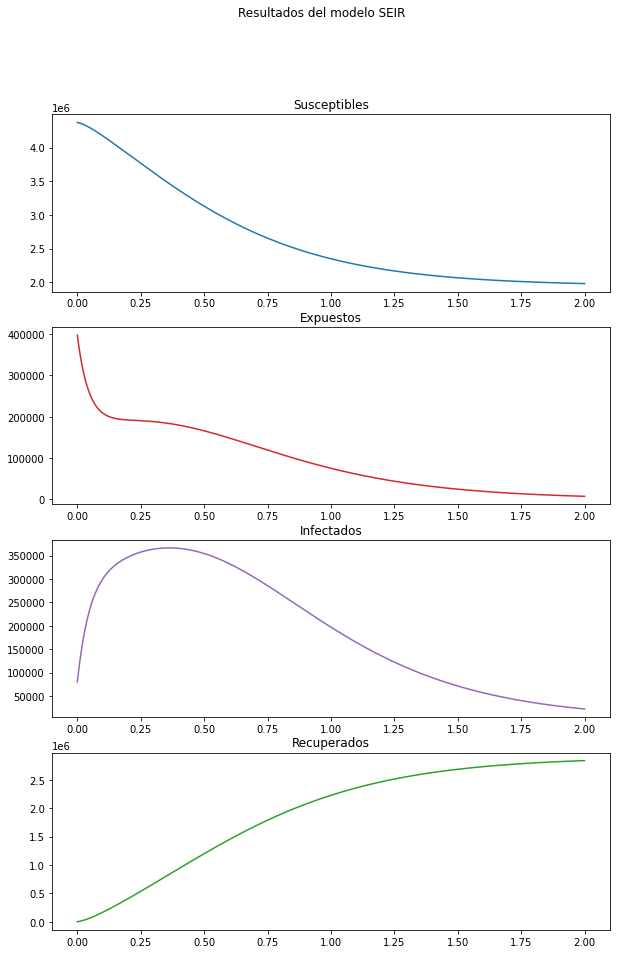

In [ ]:
import matplotlib.ticker as ticker
figure,axes = PyPlot.subplots(4,figsize=(10,15))
figure.suptitle("Resultados del modelo SEIR")

axes[0].set_title("Susceptibles")
axes[0].plot(seirModel.time,S.value,'tab:blue')

axes[1].set_title("Expuestos")
axes[1].plot(seirModel.time,E.value,'tab:red')

axes[2].set_title("Infectados")
axes[2].plot(seirModel.time,I.value,'tab:purple')

axes[3].set_title("Recuperados")
axes[3].plot(seirModel.time,R.value,'tab:green')

PyPlot.show()


Una forma alternativa de aproximarnos al problema epidemiológico, es fijar las tasas de cambio de los Susceptibles, Expuestos, Infectados y Recuperados y averiguar cuanto debería ser la población 

Vamos a utilizar GEKKO para averiguar cual es el punto de equilibrio de este sistema.

In [ ]:
seirEquilibrio = GEKKO(remote=False)
S = seirEquilibrio.Var(value=S_0)
E = seirEquilibrio.Var(value=E_0)
I = seirEquilibrio.Var(value=I_0)
R = seirEquilibrio.Var(value=R_0)
#Definimos el sistema de ecuaciones
seirEquilibrio.Equations([mu-nu*S-r*beta*S*I/(S+E+I+R) <=1,
                          r*beta*S*I/(S+E+I+R)-epsilon*E<=1,
                          epsilon*E-(gamma+nu)*I<=2,
                          gamma*I-nu*R>=1])
#now we solve the model
#ponemos la función objetivo
seirEquilibrio.Obj(-R)
seirEquilibrio.solve(disp=False)
#e imprimimos los resultados
print("máximo del sistema")
print("S*","{:,.2f}".format(S.value[0]))
print("E*","{:,.2f}".format(E.value[0]))
print("I*","{:,.2f}".format(I.value[0]))
print("R*","{:,.2f}".format(R.value[0]))

máximo del sistema
S* 24,971,616.80
E* 0.90
I* 1.53
R* 1,695,048.34
